# Interactive examples of data presentation

In [1]:
import pandas as pd
import seaborn.objects as so
import matplotlib as plt
import numpy as np
import math
import statistics

## Data structure

In [22]:
# FIXME: set identifier prefix and simulator
prefix = "pow9pow21"
batches = 3

def gen_raw_dfs(backend: str) -> list[pd.DataFrame]:
    dfs = []
    for i in range(batches):
        dfs.append(pd.read_csv(f"data/{prefix}-{i+1}-{backend}.csv"))

    return dfs

gamdpy_dfs = gen_raw_dfs("gamdpy")
gamdpy_at_dfs = gen_raw_dfs("gamdpy-at")
lammps_dfs = gen_raw_dfs("lammps")

In [8]:
# TPS
def gen_tps_dfs(dfs: list[pd.DataFrame]) -> list[pd.DataFrame]:
    n_tps_dfs = []
    for df in dfs:
        n_tps_dfs.append(pd.DataFrame({
            "n_atoms": df["n_atoms"],
            "tps": df["tps"],
        }).dropna().drop_duplicates("tps"))

    return n_tps_dfs

def get_avg_tps(dfs: list[pd.DataFrame]) -> list[float]:
    avg_tps = []
    for i in range(len(dfs[0])):
        sum = 0
        for df in dfs:
            sum += df.iloc[i]["tps"]
        avg = sum/3
        avg_tps.append(avg)

    return avg_tps

def get_sd_tps(dfs: list[pd.DataFrame]) -> list[float]:
    sd_tps = []
    for i in range(len(dfs[0])):
        std = []
        for df in dfs:
            std.append(df.iloc[i]["tps"])
        sd_tps.append(statistics.stdev(std))

    return sd_tps

gamdpy_tps_dfs = gen_tps_dfs(gamdpy_dfs)
gamdpy_at_tps_dfs = gen_tps_dfs(gamdpy_at_dfs)
lammps_tps_dfs = gen_tps_dfs(lammps_dfs)

gamdpy_avg_tps = get_avg_tps(gamdpy_tps_dfs)
gamdpy_at_avg_tps = get_avg_tps(gamdpy_at_tps_dfs)
lammps_avg_tps = get_avg_tps(lammps_tps_dfs)

gamdpy_sd_tps = get_sd_tps(gamdpy_tps_dfs)
gamdpy_at_sd_tps = get_sd_tps(gamdpy_at_tps_dfs)
lammps_sd_tps = get_sd_tps(lammps_tps_dfs)

In [9]:
# POWER
def get_avg_power(dfs: list[pd.DataFrame]) -> list[float]:
    avg_power = []
    for system_size in dfs[0].dropna().drop_duplicates("n_atoms")["n_atoms"]:
        sum = 0
        for df in dfs:
            sum += df.query(f"is_running == True and n_atoms == {system_size}")["total"].mean()
        avg = sum/3
        avg_power.append(avg)

    return avg_power

def get_sd_power(dfs: list[pd.DataFrame]) -> list[float]:
    sd_power = []
    for system_size in dfs[0].dropna().drop_duplicates("n_atoms")["n_atoms"]:
        sum = 0
        for df in dfs:
            sum += df.query(f"is_running == True and n_atoms == {system_size}")["total"].std()
        avg = sum/3
        sd_power.append(avg)

    return sd_power

gamdpy_avg_power = get_avg_power(gamdpy_dfs)
gamdpy_at_avg_power = get_avg_power(gamdpy_at_dfs)
lammps_avg_power = get_avg_power(lammps_dfs)

gamdpy_sd_power = get_sd_power(gamdpy_dfs)
gamdpy_at_sd_power = get_sd_power(gamdpy_at_dfs)
lammps_sd_power = get_sd_power(lammps_dfs)

In [30]:
# COMPLETE DATAFRAME
def gen_complete_df(
    n_tps_dfs: list[pd.DataFrame],
    avg_tps: list[float],
    sd_tps: list[float],
    avg_power: list[float],
    sd_power: list[float]
) -> pd.DataFrame:
    final_df = pd.DataFrame({
        "n_atoms": n_tps_dfs[0]["n_atoms"],
        "tps": avg_tps,
        "tps_sd": sd_tps,
        "power": avg_power,
        "power_sd": sd_power,
    })
    final_df["power_min"] = final_df["power"] - final_df["power_sd"]
    final_df["power_max"] = final_df["power"] + final_df["power_sd"]

    return final_df

gamdpy_complete_df = gen_complete_df(
    gamdpy_tps_dfs,
    gamdpy_avg_tps,
    gamdpy_sd_tps,
    gamdpy_avg_power,
    gamdpy_sd_power,
)
gamdpy_at_complete_df = gen_complete_df(
    gamdpy_at_tps_dfs,
    gamdpy_at_avg_tps,
    gamdpy_at_sd_tps,
    gamdpy_at_avg_power,
    gamdpy_at_sd_power,
)
lammps_complete_df = gen_complete_df(
    lammps_tps_dfs,
    lammps_avg_tps,
    lammps_sd_tps,
    lammps_avg_power,
    lammps_sd_power,
)

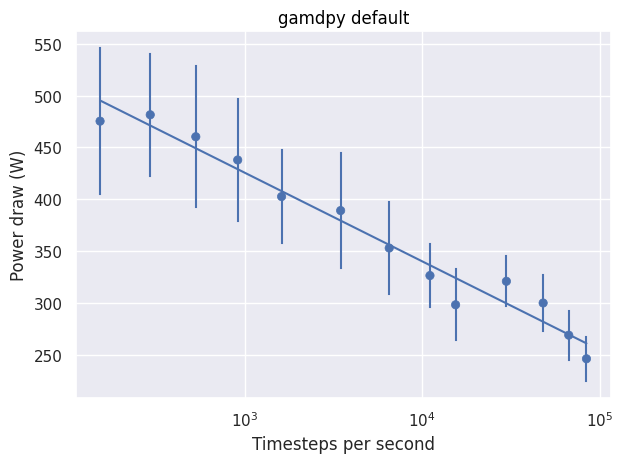

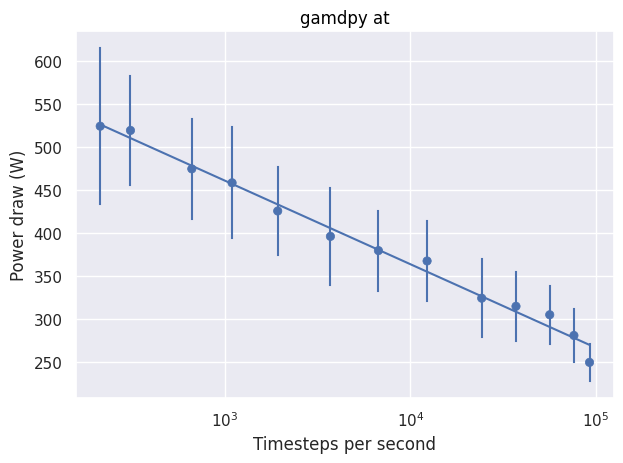

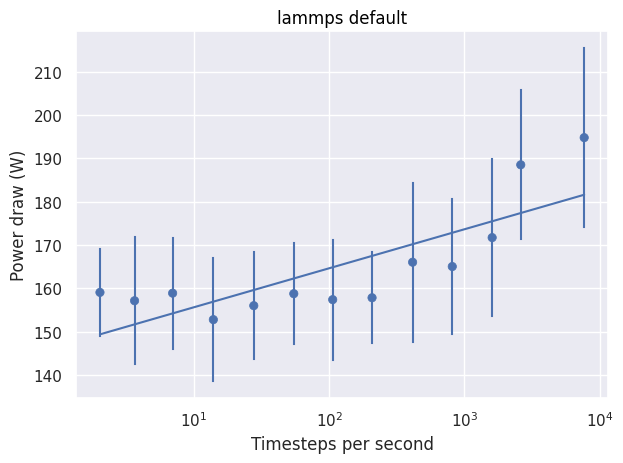

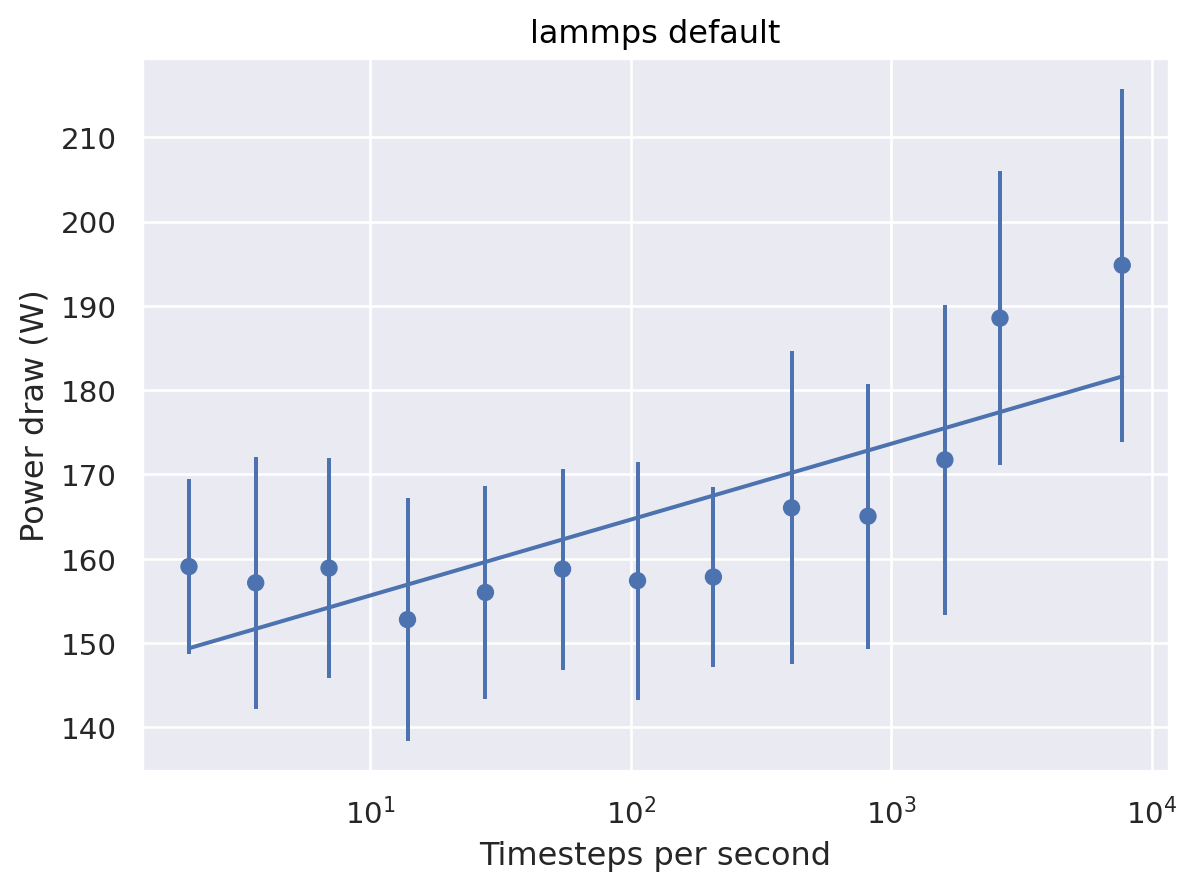

In [32]:
def tps_power_plot(
    df: pd.DataFrame,
    title: str
) -> so.Plot:
    return (
        so.Plot(data=df,  x=df.tps, y=df.power)
        .add(so.Dot())
        .add(so.Range(), ymin="power_min", ymax="power_max")
        # .scale(x=so.Continuous().tick(at=np.arange(0, 90000, 10000)))
        .scale(x="log")
        .add(so.Line(), so.PolyFit(order=1))
        # .limit(x=(95000, 0))
        # .layout(extent=(10000, 10000, 10000, 10000))
        .label(
            x="Timesteps per second",
            y="Power draw (W)",
            title=title
        )

        # for x, y in zip(exponents, spike_stats['gpu']):
        # plt.text(x, y + 8, f"{y:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold', color='blue')
    )

gamdpy_tps_power_plot = tps_power_plot(
    gamdpy_complete_df,
    "gamdpy default"
)
gamdpy_at_tps_power_plot = tps_power_plot(
    gamdpy_at_complete_df,
    "gamdpy at"
)
lammps_tps_power_plot = tps_power_plot(
    lammps_complete_df,
    "lammps default"
)

gamdpy_tps_power_plot.show()
gamdpy_at_tps_power_plot.show()
lammps_tps_power_plot.show()

gamdpy_tps_power_plot.save("fig/gamdpy_tps_power")
gamdpy_at_tps_power_plot.save("fig/gamdpy_at_tps_power")
lammps_tps_power_plot.save("fig/lammps_tps_power")

In [28]:
display("gamdpy default", gamdpy_complete_df)
display("gamdpy at", gamdpy_at_complete_df)
display("lammps default", lammps_complete_df)

'gamdpy default'

,n_atoms,tps,tps_sd,power,power_sd,power_min,power_max
46,512.0,84417.868224,29.648788,246.204556,21.345565,224.858990,267.550121
79,1024.0,67082.554532,12.200695,268.952188,23.499265,245.452923,292.451454
114,2048.0,48103.810529,189.731707,299.973744,27.341033,272.632711,327.314778
152,4096.0,29852.842996,7.779480,320.900927,24.206195,296.694732,345.107123
195,8192.0,15440.155153,13.741721,298.255953,34.204204,264.051750,332.460157
229,16384.0,11070.434902,1.891143,326.434827,30.253739,296.181089,356.688566
268,32768.0,6523.308226,7.237041,352.944161,44.382333,308.561827,397.326494
308,65536.0,3472.856332,24.084684,389.084771,55.036342,334.048429,444.121113
352,131072.0,1613.259334,9.636712,402.577134,44.573799,358.003335,447.150932
390,262144.0,912.603518,0.962181,437.849744,59.215310,378.634434,497.065054


'gamdpy at'

,n_atoms,tps,tps_sd,power,power_sd,power_min,power_max
46,512.0,92765.152168,36.332178,250.007137,21.526275,228.480862,271.533413
78,1024.0,76386.325246,7.945556,281.307529,31.289581,250.017948,312.597110
112,2048.0,56556.911325,7.719816,305.359726,33.958073,271.401653,339.317799
149,4096.0,37181.303178,20.024453,315.203225,39.778600,275.424625,354.981825
185,8192.0,24276.942299,7.223110,324.625169,45.619098,279.006071,370.244267
229,16384.0,12312.799666,9.899223,367.894219,46.373608,321.520611,414.267827
269,32768.0,6723.768496,11.761791,379.961189,46.407346,333.553843,426.368535
308,65536.0,3702.119445,24.955784,396.478741,56.490032,339.988709,452.968773
347,131072.0,1922.217083,4.995642,425.982235,51.719994,374.262241,477.702229
386,262144.0,1090.115221,4.521224,458.788654,64.368279,394.420374,523.156933


'lammps default'

,n_atoms,tps,tps_sd,power,power_sd,power_min,power_max
31,512.0,7695.566600,203.115648,194.813885,20.705284,174.108601,215.519169
66,1024.0,2611.430491,90.119729,188.538183,17.196540,171.341644,205.734723
91,2048.0,1604.366136,49.036346,171.726168,18.125879,153.600290,189.852047
119,4096.0,813.157508,2.528949,165.042125,15.498143,149.543983,180.540268
147,8192.0,413.684663,0.173371,166.040185,18.341381,147.698803,184.381566
175,16384.0,207.316772,2.625099,157.834272,10.461505,147.372767,168.295777
203,32768.0,106.012908,0.218124,157.395488,13.881060,143.514428,171.276549
231,65536.0,54.646480,0.218221,158.771226,11.685288,147.085938,170.456514
258,131072.0,27.638495,0.071977,156.003229,12.415566,143.587663,168.418795
286,262144.0,13.876073,0.017567,152.778465,14.152092,138.626373,166.930557


## Presentation & analysis

### Stacked graphs

Displays two graphs stacked on top of each other. Easily readable.

In [ ]:
p = (
    so.Plot(data=df, x=df.time)
    .add(so.Area(edgewidth=0), y="total")
    .add(so.Line(linewidth=1), y="total", label="Total")
    .add(so.Area(edgewidth=0, color="green"), y="gpu")
    .add(so.Line(linewidth=1, color="green"), y="gpu", label="GPU")
    .label(
        x="Time (s)",
        y="Power draw (W)",
        title=f"{sim} {identifier}",
        legend="Hardware measured"
    )
)
#p.save(f"fig/{identifier}-{sim}-stacked")  # uncomment to save
p

### Paired graph

Displays two graphs side by side. Might have a purpose in the report later on.

In [ ]:
p = (
    so.Plot(data=df, x=df.time)
    .pair(y=["gpu", "total"])
    .add(so.Area(edgewidth=0)).add(so.Line(linewidth=1))
    .label(
        x="Time (s)",
        y0="GPU power draw (W)",
        y1="Total power draw (W)",
        title=f"{sim} {identifier}"
    )
)
#p.save(f"fig/{identifier}-{sim}-paired")
p

### Band graph

Displays the interval between two y-values. Looks kinda goofy at this point.

In [ ]:
p = (
    so.Plot(df, x=df.time, ymin="gpu", ymax="total")
    .add(so.Band(edgewidth=1))
    .label(
        x="Time (sec)",
        y="Power draw (W)",
        title=f"Power draw - {sim} {identifier}"
    )
)
#p.save(f"fig/{identifier}-{sim}-band")
p